In [1]:
#here we import all modules used in this notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

In [2]:
#here we define shared functions used in this notebook

def cumulatively_categorise(column, category_limit):

    #Create list of categories to keep
    categories_list = column.value_counts().iloc[:category_limit-1].index

    #Replace all instances not in our new categories by other  
    new_column=column.apply(lambda x: x if x in categories_list else 'other')

    #Return transformed column
    return new_column

def get_outliers_iqr(column):

    outliers = []
    sorted_column = sorted(column)
    q1 = np.percentile(sorted_column, 25)
    q3 = np.percentile(sorted_column, 75)
    
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)

    condition = (column > lwr_bound) & (column < upr_bound)
    
    return condition

def visualize_features(feature_names):

    cat_features = df.select_dtypes(include='object').columns
    num_features = df.select_dtypes(include='number').columns

    for feature_name in feature_names:

        series = df[feature_name]

        if feature_name in cat_features:
            value_counts = series.value_counts()
            if len(value_counts) < 100:
                title = '\'' + feature_name + '\' value counts'
                plt.figure(figsize=(14,3))
                ax = sns.barplot(value_counts)
                ax.set_title(title)
                ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
                if feature_name in ['manufacturer']:
                    plt.xticks(rotation=-90)
                plt.show()
    
        if feature_name in num_features:
            title = '\'' + feature_name + '\' value counts'
            plt.figure(figsize=(14,3))
            ax = sns.histplot(series)
            ax.set_title(title)
            if feature_name in ['price', 'odometer']:
                ax.get_xaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
            ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
            plt.show()

### Business Understanding
Using the car database provided to us, we will identify which features of used cars are most corrolated with their price. This will help the dealership optimize their inventory of cars by prioritizing cars that have better sale prices.

One way we will do this is by visualizing features individually against the car price.

The second way will be by building and comparing machine learning models that are able to predict the car price based on the features. Having picked the best model, we will be able to examine the model's importance of features, which will provide insight into which features have the most impact on the sale price.

### Data Understanding
#### 1. Load and get a summary of the cars database

In [3]:
df = pd.read_csv('data/vehicles.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

<b>Analysis:</b>
- It appears that all features are of the right type.
- We can see missing values in some columns.
- There are some unnessary columns.

#### 2. Check the cardinality of the categorical features

In [4]:
cat_features = df.select_dtypes(include='object').columns

for i in cat_features:
    print (i, len(df[i].unique()))

region 404
manufacturer 43
model 29650
condition 7
cylinders 9
fuel 6
title_status 7
transmission 4
VIN 118247
drive 4
size 5
type 14
paint_color 13
state 51


<b>Analysis</b>: We can see that some features have very high cardinality.

#### 3. Check features for missing values

In [5]:
missing_ratios = df.isna().sum() / df.shape[0]
missing_ratios

id              0.000000
region          0.000000
price           0.000000
year            0.002823
manufacturer    0.041337
model           0.012362
condition       0.407852
cylinders       0.416225
fuel            0.007058
odometer        0.010307
title_status    0.019308
transmission    0.005988
VIN             0.377254
drive           0.305863
size            0.717675
type            0.217527
paint_color     0.305011
state           0.000000
dtype: float64

<b>Analysis</b>: We can see that some columns have a very high proportion of missing values.

#### 4. Visualize features for potential issues
We will be visualizing numerical features and categorical features with low cardinality.

Note: we are unable to visualize the price in it's current state as there appears to be some kind of error that prevents the visualization from showing. We will visit the price column after the data preparation.

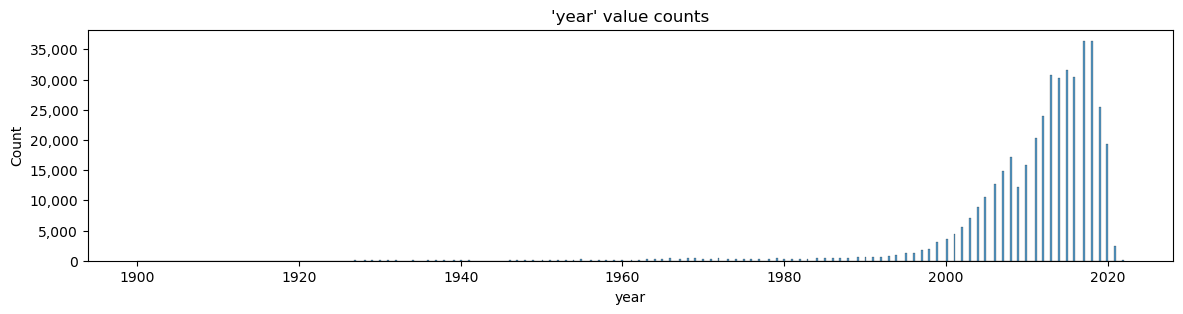

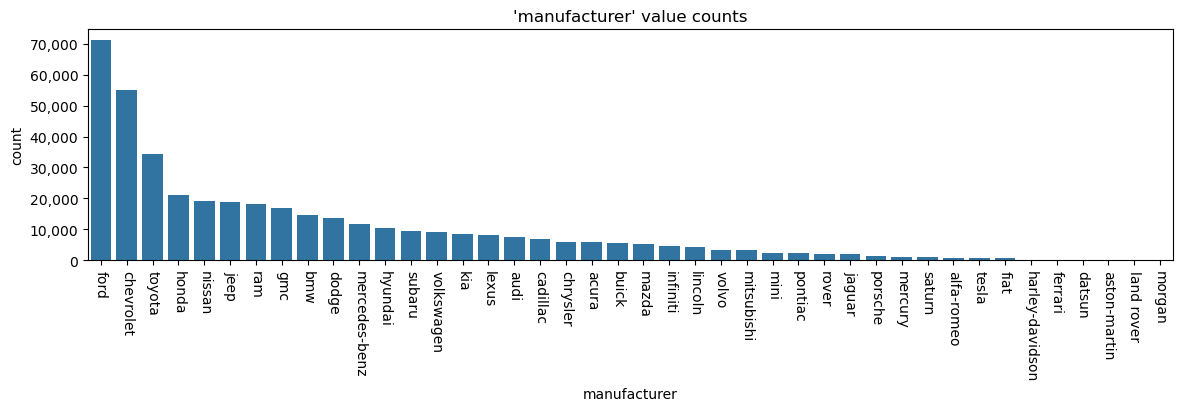

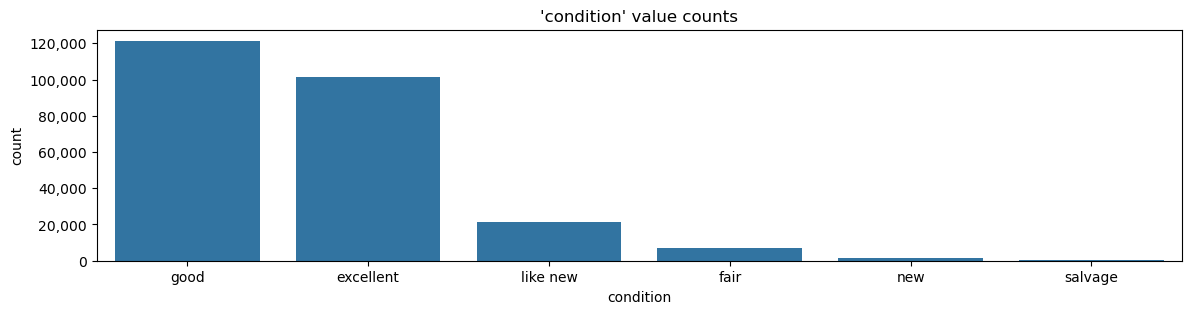

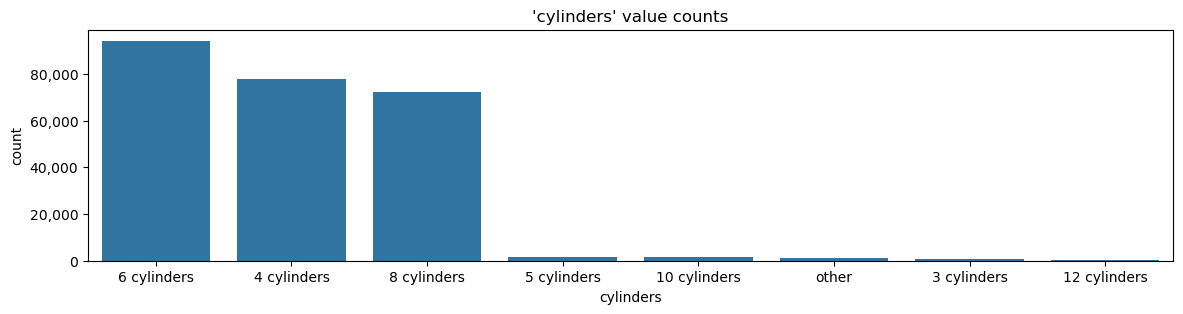

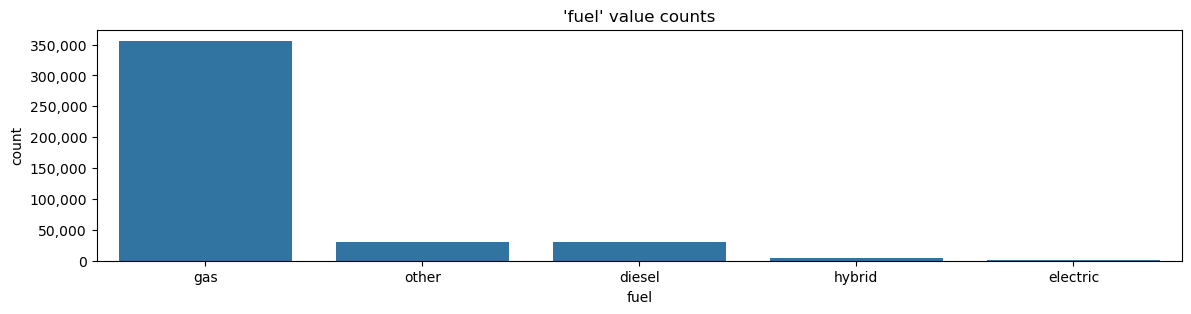

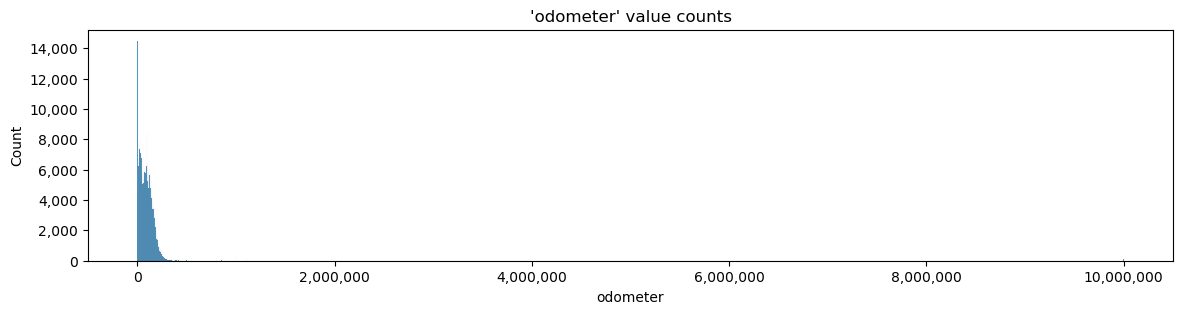

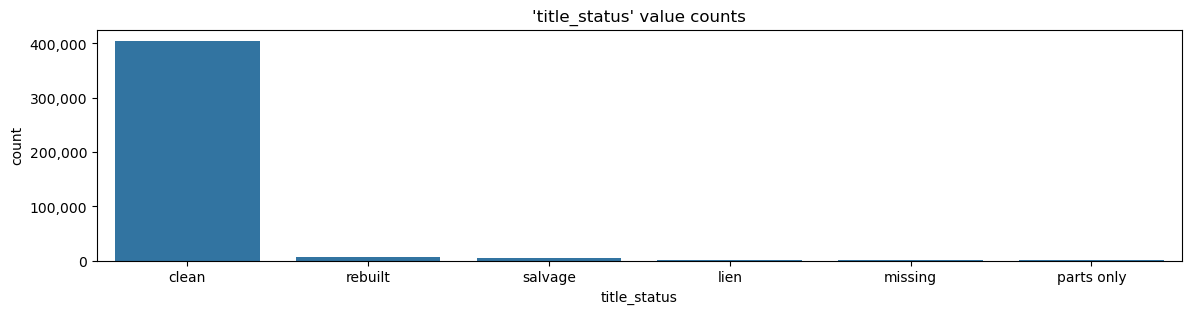

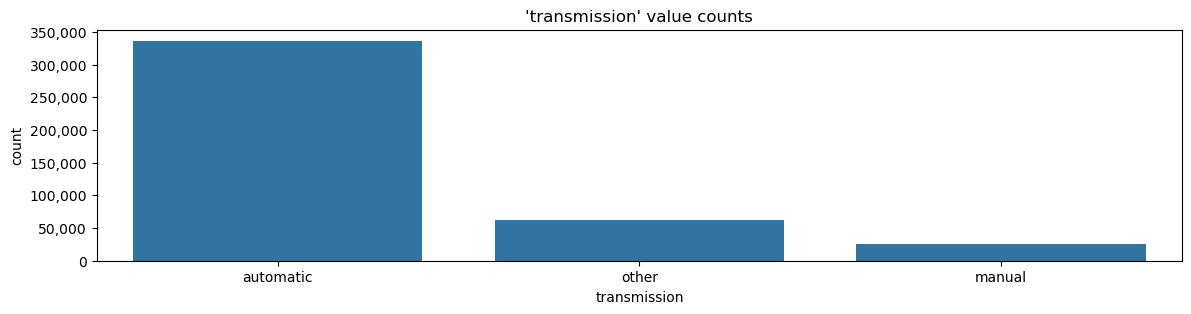

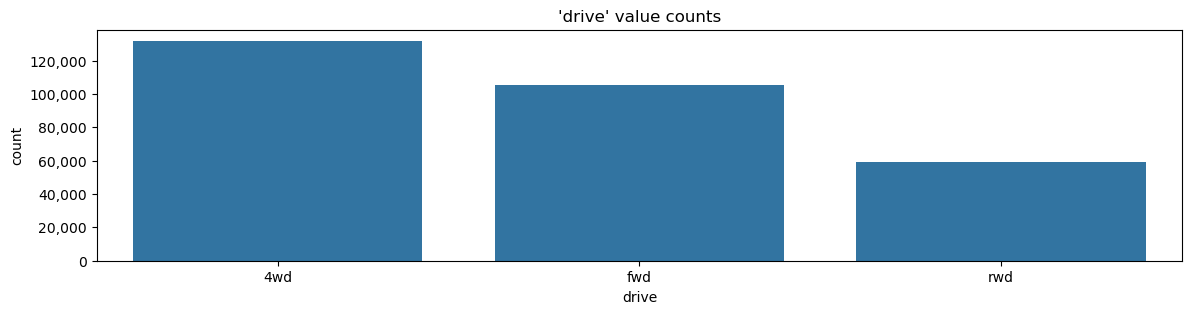

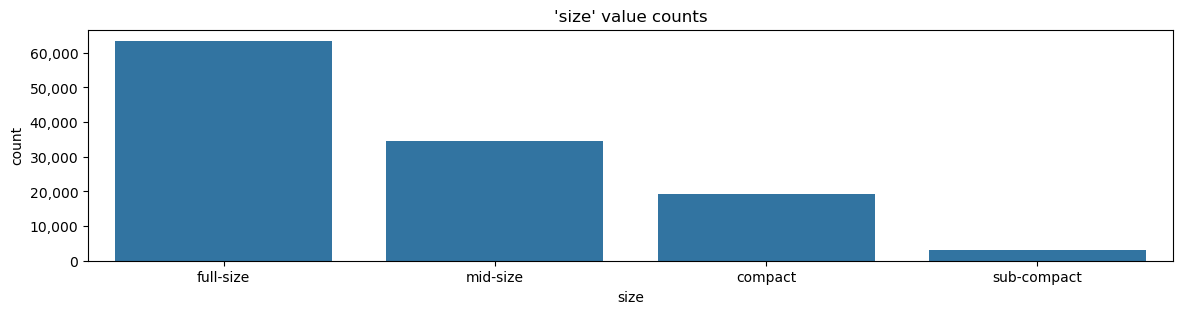

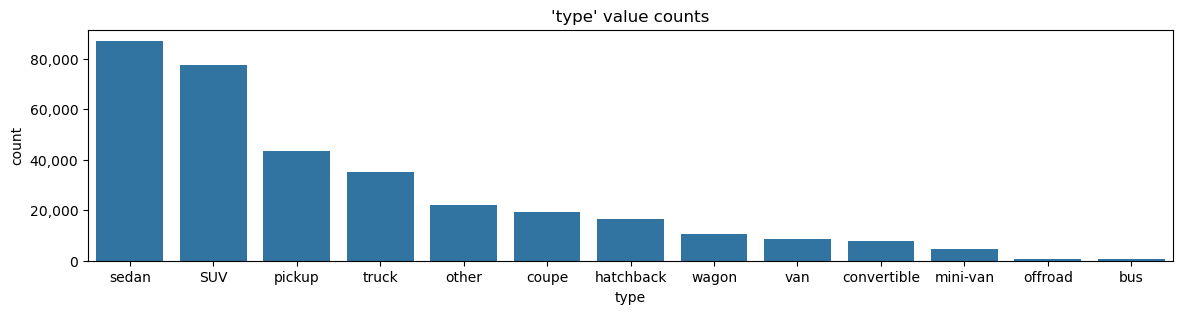

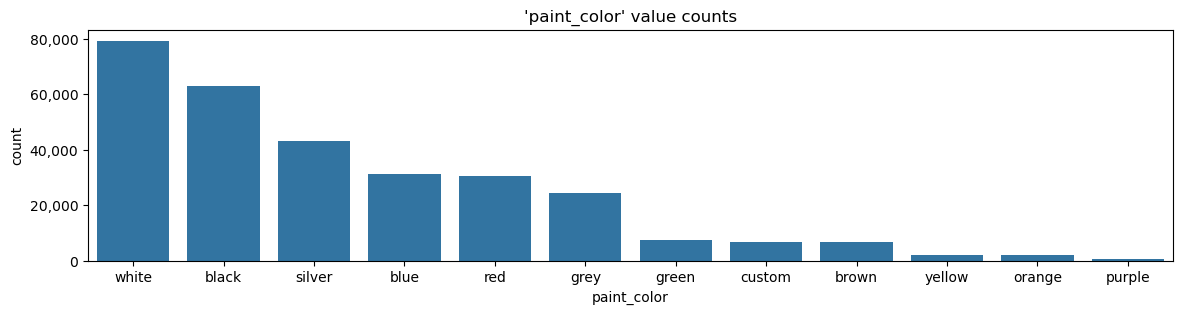

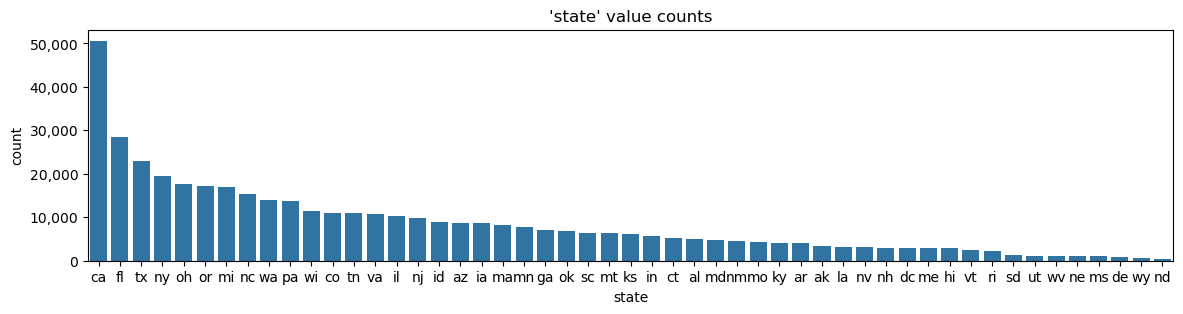

In [6]:
features = df.columns

# drop unnessary columns ('id', 'VIN'), and 'price'
features = features.drop(['id', 'VIN', 'price'])

visualize_features(features)

### Data Preparation

#### 1. Drop unnessary columns

In [7]:
#drop unnecessary columns
unnecessary_columns = ['id', 'VIN']
df.drop(columns=unnecessary_columns, inplace=True)

#### 2. Manually remove rows with potential errors
We will take care of the following problems:
- Remove entries where `price` is less than 500 as these are special conditions or mistakes that do not reflect the actual sale price of the car.
- Remove entries where `odometer` is less than 1,250 as these are likely mistakes that do not accurately reflect the actual mileage of the car.
- Remove entries where the value in the `model` shows up 5 or less times. Upon inspecting the model values, we can see that infrequent entries can usually be mistakes (i.e. the model written a different way than usual).

In [8]:
#manually remove rows with potential errors
condition = (df['price'] > 500) & (df['odometer'] > 1250)

model_value_counts = df['model'].value_counts()
models_to_keep = model_value_counts.index[model_value_counts > 5]
models_to_keep = models_to_keep.drop('#NAME?')
condition = condition & df['model'].isin(models_to_keep)

df = df[condition]

#### 3. Remove features with too many missing rows
Here we will remove any feature that is missing in more than 20% of the entries.

In [9]:
#drop columns with too many missing rows
threshold = 0.2
missing_ratios = df.isna().sum() / df.shape[0]
indices_to_drop = missing_ratios[missing_ratios > threshold].index
df.drop(columns=indices_to_drop, inplace=True)

#### 4. Drop rows with missing features
The remaining features have a small proportion of missing values, therefore it is safe to drop these rows.

In [10]:
#drop rows with missing values
df.dropna(inplace=True)

#### 5. Remove outliers
We will remove outliers from numerical columns using the IQR method.

In [11]:
#remove outliers from numerical columns using iqr method
condition = np.full(df.shape[0], True)
for series_name, series in df.select_dtypes(include='number').items():
    condition = condition & get_outliers_iqr(series)
df = df[condition]

#### 6. Consider limiting categorical features with high cardinality
Here I have decided not to limit categorical features, as the results without limiting them were significantly better. Keeping high cardinality features leads to higher training times for the models, but worth it with the much better results.

In [12]:
#limit categorical features with high cardinality
# for index in df.select_dtypes(include='object').columns:
#     category_limit = 100 
#     if len(df[index].unique()) > category_limit:
#         df[index] = cumulatively_categorise(df[index], category_limit)
# for cat_column in df.select_dtypes(include='object').columns:  
#     print(cat_column, len(df[cat_column].unique()))

#### 7. Visualize features for potential issues
Here we will visualize the prepared form of the features and check if additional changes are needed.

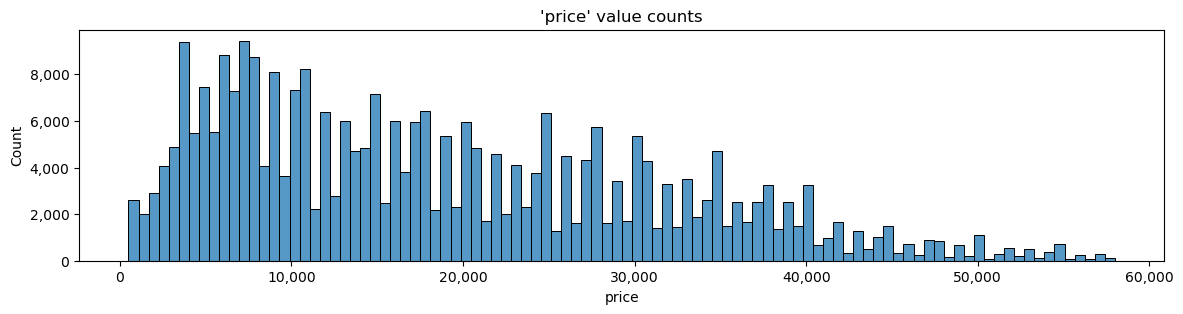

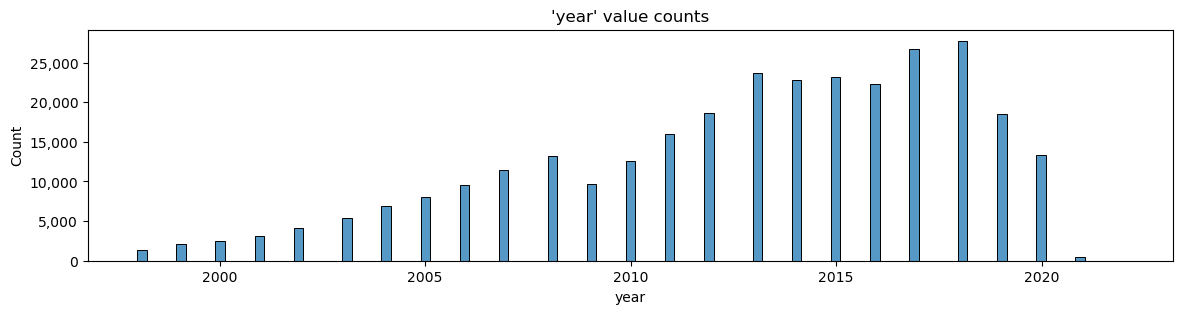

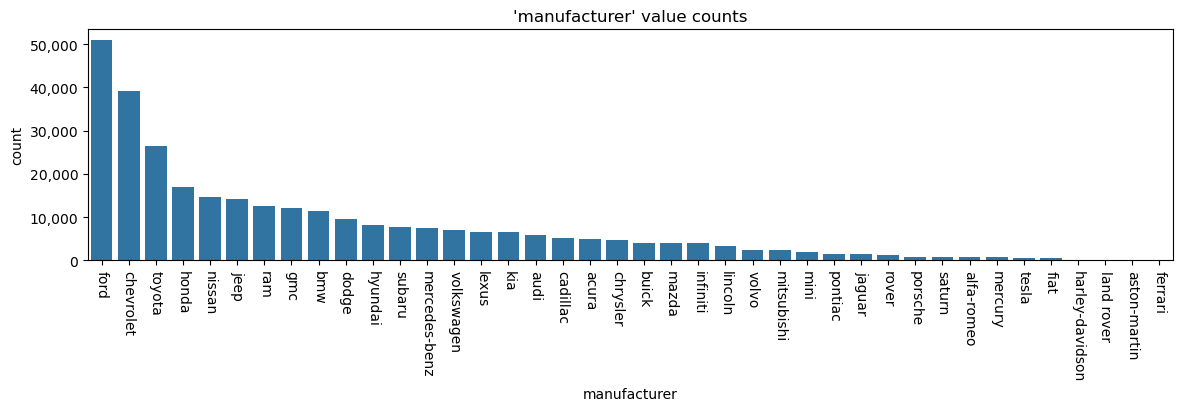

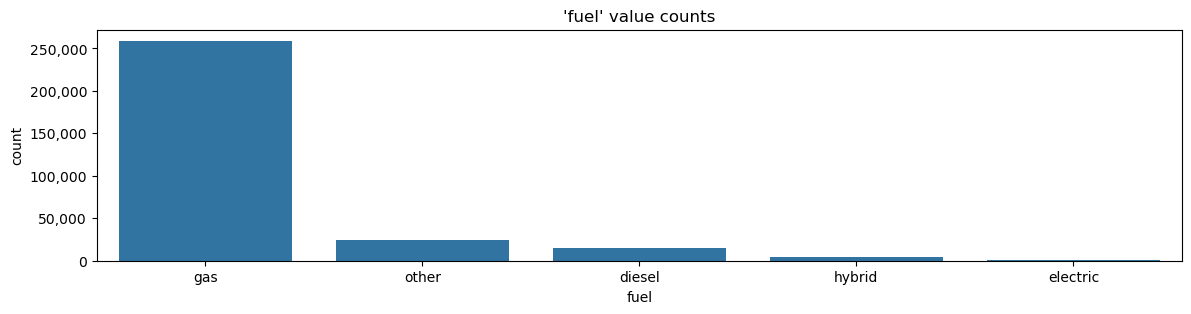

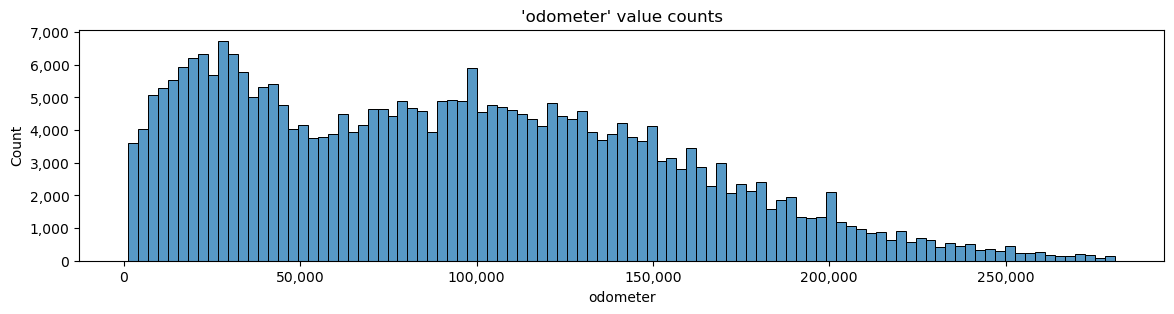

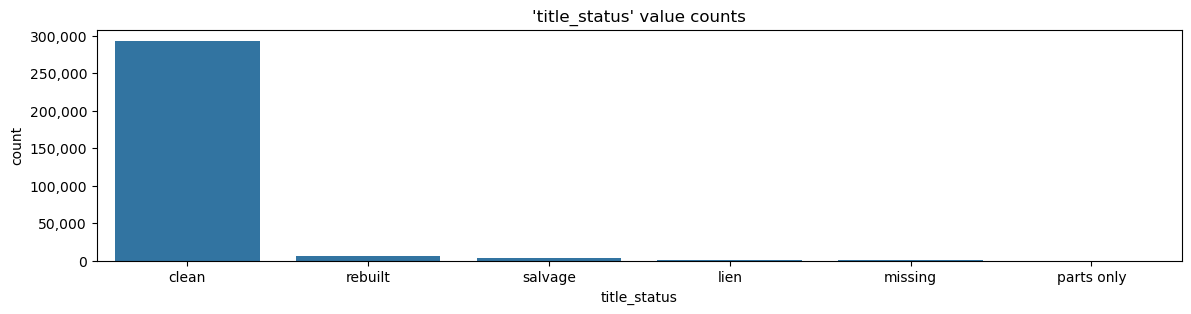

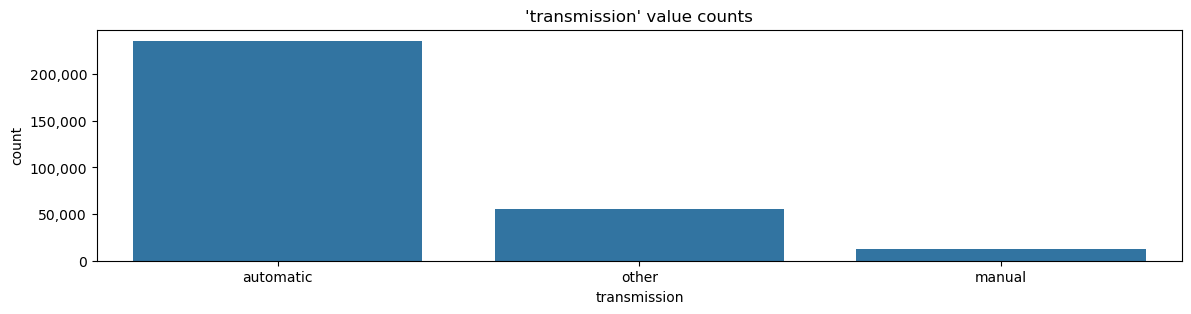

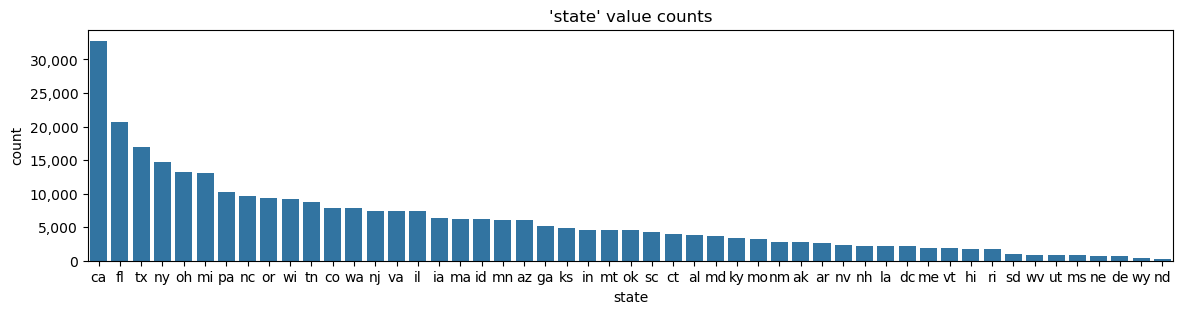

In [13]:
features = df.columns

visualize_features(features)

<b>Analysis</b>: We can see that all columns look good and ready to be used in modeling.

#### 8. Visualize relationship of features to price

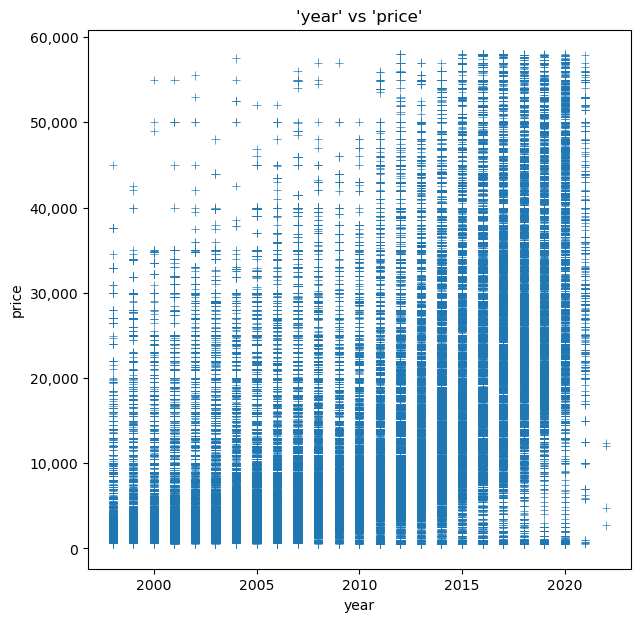

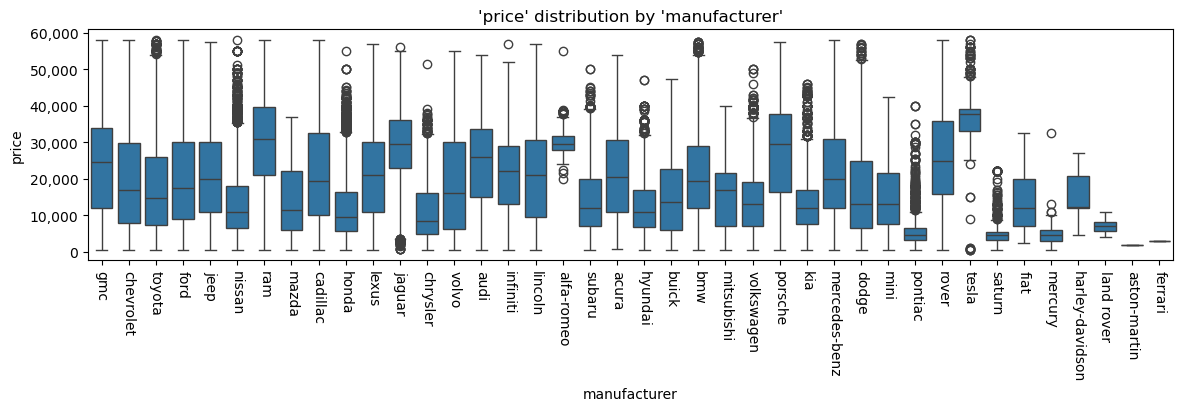

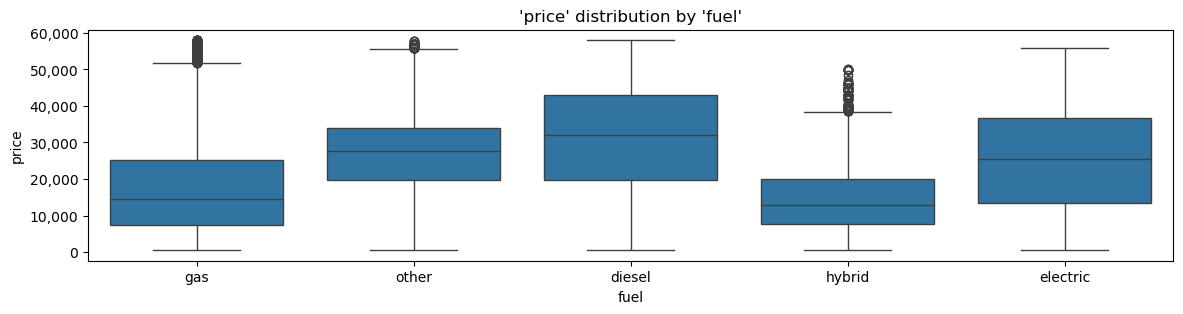

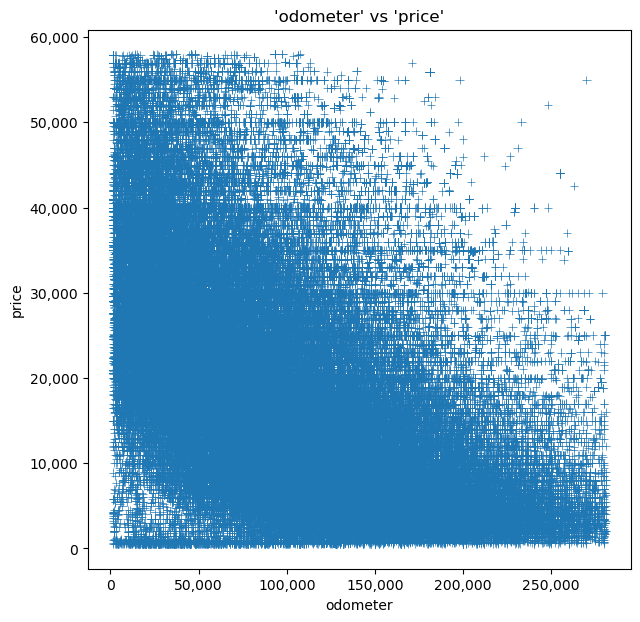

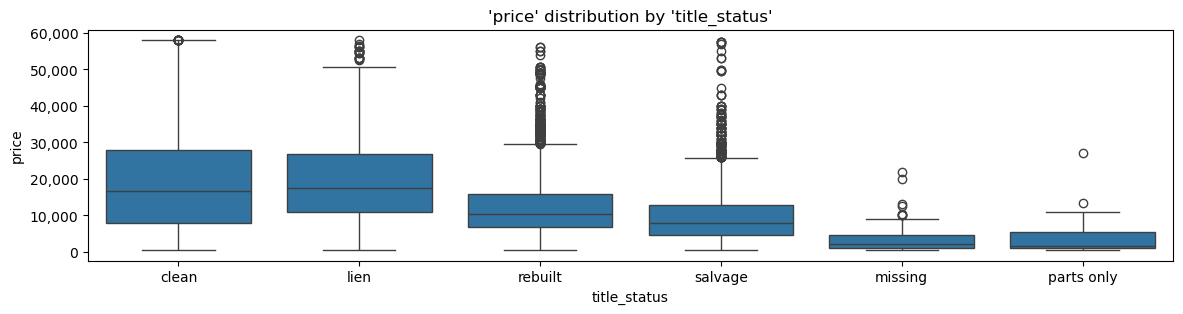

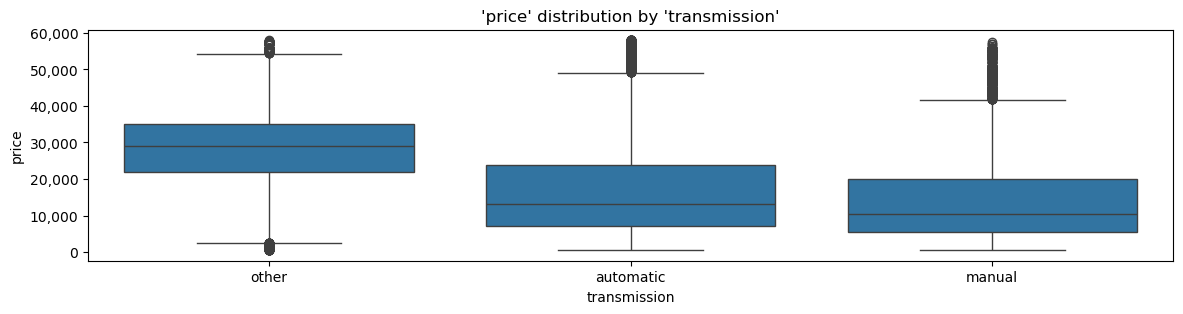

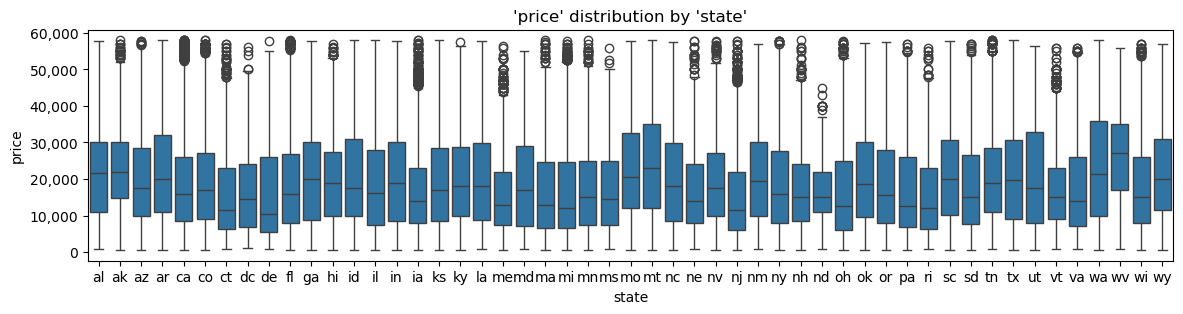

In [14]:
cat_features = df.select_dtypes(include='object').columns
num_features = df.select_dtypes(include='number').columns

feature_names = df.columns.drop('price')

for feature_name in feature_names:

    series = df[feature_name]

    if feature_name in cat_features:
        value_counts = series.value_counts()
        if len(value_counts) < 100:
            title = '\'price\' distribution by \'' + feature_name + '\''
            plt.figure(figsize=(14,3))
            ax = sns.boxplot(df, x=feature_name, y='price')
            ax.set_title(title)
            ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
            if feature_name in ['manufacturer']:
                plt.xticks(rotation=-90)
            plt.show()

    if feature_name in num_features:
        title = '\'' + feature_name + '\' vs \'price\''
        plt.figure(figsize=(7,7))
        ax = sns.scatterplot(df, x=feature_name, y='price', style=False, legend=False, markers='+')
        ax.set_title(title)
        if feature_name == 'odometer':
            ax.get_xaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        plt.show()

### Modeling
- Here we will build and run various models and check their accuracy using mean absolute error (MAE) and coefficient of determination (R2).
- We will create a models dictionary that will store our various models as we create them so that we can refer back to them if needed.

#### 1. Seperate the target variable from the features and create a train and test split.
We will use the train piece for model training and use the test piece for model evaluation.

In [15]:
X = df.drop('price', axis = 1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

models = {}

#### 1. Build and run Linear Regression model
- Preprocess numerical features with `StandardScaler()`
- Preprocess categorical features with `OneHotEncoder()`
- Apply `PolynomialFeatures()` to numerical features and use `GridSearchCV()` to find the optimal degree parameter

In [16]:
cat_features = X.select_dtypes(include='object').columns
num_features = X.select_dtypes(include='number').columns

num_preprocessor = Pipeline(steps=[
    ('pf', PolynomialFeatures(include_bias=False)),
    ('ss', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[ 
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
    ('num', num_preprocessor, num_features)                                                       
])

model = Pipeline(steps=[
    ('prep', preprocessor),
    ('model', LinearRegression())
])

param_grid = {
    'prep__num__pf__degree': range(1, 10)
}

gs = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=2,
    verbose=1
)

gs.fit(X_train, y_train)

models['LinearRegression'] = gs.best_estimator_

#print results
print(type(gs.best_estimator_.named_steps['model']))
print('Best parameters: ', gs.best_params_)
train_mae = round(mean_absolute_error(y_train, gs.predict(X_train)))
test_mae = round(mean_absolute_error(y_test, gs.predict(X_test)))
print('Train MAE: ' + f"{train_mae:,}")
print('Test MAE: ' + f"{test_mae:,}")
train_r2 = round(r2_score(y_train, gs.predict(X_train)), 2)
test_r2 = round(r2_score(y_test, gs.predict(X_test)), 2)
print('Train R2: ' + f"{train_r2:,}")
print('Test R2: ' + f"{test_r2:,}")

Fitting 2 folds for each of 9 candidates, totalling 18 fits
<class 'sklearn.linear_model._base.LinearRegression'>
Best parameters:  {'prep__num__pf__degree': 8}
Train MAE: 2,772
Test MAE: 2,819
Train R2: 0.88
Test R2: 0.87


#### 2. Build and run Ridge Regression model
- Preprocess numerical features with `StandardScaler()`
- Preprocess categorical features with `OneHotEncoder()`
- Apply `PolynomialFeatures()` to numerical features and use `GridSearchCV()` to find the optimal degree parameter
- Use `GridSearchCV()` to find the optimal alpha parameter

In [17]:
cat_features = X.select_dtypes(include='object').columns
num_features = X.select_dtypes(include='number').columns

num_preprocessor = Pipeline(steps=[
    ('pf', PolynomialFeatures(include_bias=False)),
    ('ss', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[ 
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
    ('num', num_preprocessor, num_features)                                                       
])

model = Pipeline(steps=[
    ('prep', preprocessor),
    ('model', Ridge())
])

param_grid = {
    'prep__num__pf__degree': range(1, 10),
    'model__alpha' : np.logspace(-2, 4, num=10)
}

gs = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=2,
    verbose=1
)

gs.fit(X_train, y_train)

models['Ridge'] = gs.best_estimator_

#print results
print(type(gs.best_estimator_.named_steps['model']))
print('Best parameters: ', gs.best_params_)
train_mae = round(mean_absolute_error(y_train, gs.predict(X_train)))
test_mae = round(mean_absolute_error(y_test, gs.predict(X_test)))
print('Train MAE: ' + f"{train_mae:,}")
print('Test MAE: ' + f"{test_mae:,}")
train_r2 = round(r2_score(y_train, gs.predict(X_train)), 2)
test_r2 = round(r2_score(y_test, gs.predict(X_test)), 2)
print('Train R2: ' + f"{train_r2:,}")
print('Test R2: ' + f"{test_r2:,}")

Fitting 2 folds for each of 90 candidates, totalling 180 fits
<class 'sklearn.linear_model._ridge.Ridge'>
Best parameters:  {'model__alpha': 0.21544346900318834, 'prep__num__pf__degree': 8}
Train MAE: 2,782
Test MAE: 2,828
Train R2: 0.88
Test R2: 0.87


#### 3. Build and run Lasso Regression model
- Preprocess numerical features with `StandardScaler()`
- Preprocess categorical features with `OneHotEncoder()`
- We will apply `PolynomialFeatures()` to numerical features and use `GridSearchCV()` to find the optimal degree parameter
- We will use `GridSearchCV()` to find the optimal alpha parameter

In [18]:
cat_features = X.select_dtypes(include='object').columns
num_features = X.select_dtypes(include='number').columns

num_preprocessor = Pipeline(steps=[
    ('pf', PolynomialFeatures(include_bias=False)),
    ('ss', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[ 
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
    ('num', num_preprocessor, num_features)                                                       
])

model = Pipeline(steps=[
    ('prep', preprocessor),
    ('model', Lasso(tol=1e-1))
])

param_grid = {
    'prep__num__pf__degree': range(1, 10),
    'model__alpha' : np.logspace(-2, 4, num=10)
}

gs = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=2,
    verbose=1
)

gs.fit(X_train, y_train)

models['Lasso'] = gs.best_estimator_

#print results
print(type(gs.best_estimator_.named_steps['model']))
print('Best parameters: ', gs.best_params_)
train_mae = round(mean_absolute_error(y_train, gs.predict(X_train)))
test_mae = round(mean_absolute_error(y_test, gs.predict(X_test)))
print('Train MAE: ' + f"{train_mae:,}")
print('Test MAE: ' + f"{test_mae:,}")
train_r2 = round(r2_score(y_train, gs.predict(X_train)), 2)
test_r2 = round(r2_score(y_test, gs.predict(X_test)), 2)
print('Train R2: ' + f"{train_r2:,}")
print('Test R2: ' + f"{test_r2:,}")

Fitting 2 folds for each of 90 candidates, totalling 180 fits
<class 'sklearn.linear_model._coordinate_descent.Lasso'>
Best parameters:  {'model__alpha': 0.01, 'prep__num__pf__degree': 9}
Train MAE: 2,934
Test MAE: 2,978
Train R2: 0.87
Test R2: 0.86


#### 4. Build and run Random Forest Regressor model
- Preprocess numerical features with `StandardScaler()`
- Preprocess categorical features with `OneHotEncoder()`

In [19]:
cat_features = X.select_dtypes(include='object').columns
num_features = X.select_dtypes(include='number').columns

num_preprocessor = Pipeline(steps=[
    ('ss', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[ 
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
    ('num', num_preprocessor, num_features)                                                       
])

model = Pipeline(steps=[
    ('prep', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=0))
])

param_grid = {
    #none
}

gs = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=2,
    verbose=1
)

gs.fit(X_train, y_train)

models['RandomForestRegressor'] = gs.best_estimator_

#print results
print(type(gs.best_estimator_.named_steps['model']))
print('Best parameters: ', gs.best_params_)
train_mae = round(mean_absolute_error(y_train, gs.predict(X_train)))
test_mae = round(mean_absolute_error(y_test, gs.predict(X_test)))
print('Train MAE: ' + f"{train_mae:,}")
print('Test MAE: ' + f"{test_mae:,}")
train_r2 = round(r2_score(y_train, gs.predict(X_train)), 2)
test_r2 = round(r2_score(y_test, gs.predict(X_test)), 2)
print('Train R2: ' + f"{train_r2:,}")
print('Test R2: ' + f"{test_r2:,}")

Fitting 2 folds for each of 1 candidates, totalling 2 fits
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
Best parameters:  {}
Train MAE: 656
Test MAE: 1,760
Train R2: 0.99
Test R2: 0.91


### Evaluation

Let's review each model's performance:

| Model | MAE | R2 |
| :-- | --: | --: |
| LinearRegression() | 2,819 | 0.87 |
| Ridge() | 2,828 | 0.87 |
| Lasso() | 2,978 | 0.86 |
| RandomForestRegressor() | 1,760 | 0.91 |

We can see that `RandomForestRegressor()` gave superior results for this task. We will use that model as our best estimator.

#### Investigate Feature Importance

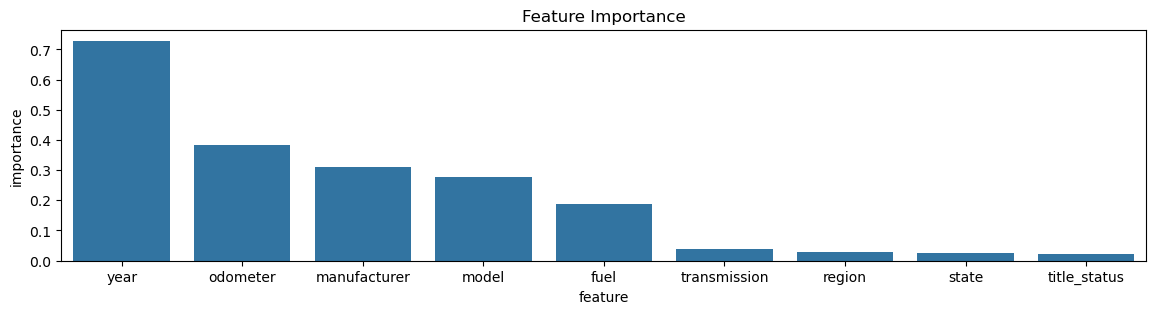

In [24]:
best_model = models['RandomForestRegressor']

pi = permutation_importance(
    best_model,
    X_train,
    y_train,
    n_jobs=-1,
    n_repeats=2,
    random_state=0
)

pi_s = pd.Series(pi.importances_mean, index=X.columns, name='importance')

plt.figure(figsize=(14,3))
ax = sns.barplot(pi_s.sort_values(ascending=False))
ax.set_title('Feature Importance')
ax.set_xlabel('feature')
plt.show()

### Deployment

Having evaluated multiple models, we have seen that `RandomForestRegressor()` performed the best for this task.

Using our best model, we are able to determine the level of impact each feature has on the price:
- We can see that `year` is the most impactful feature in determining the price of a used car
- Features with medium impact on a used car include `odometer`, `manufacturer`, `model`, and `fuel`
- The rest of the features  (`transmission`, `region`, `state`, `title_status`) have little impact on the price of a used car

Using our model, we are able to accurately and fairly price used cars. We are also able to optimize our used car inventory by keeping the ones that sell at a higher price and getting rid of the ones that sell at a lower price.